# Principal Components Regression using PCA

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error


df = pd.read_csv(r'C:\Users\Yash\Desktop\Fall 2019 Material\Multivariate Project 1\Final Project\Hitters.csv')
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])

# Let's Set up Our Data

In [2]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1)

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

In [3]:
#We'll start performing Principal Components Analysis (PCA), remembering to scale the data:
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

In [4]:
#Let's print out the first few variables of the first few principal components:
pd.DataFrame(pca.components_.T).loc[:4,:5]

,0,1,2,3,4,5
0,0.215399,-0.367806,0.058383,0.027728,0.017248,-0.103710
1,0.210356,-0.363804,0.048768,0.011653,-0.013760,-0.115771
2,0.209753,-0.232320,-0.190024,-0.266772,0.056637,-0.074143
3,0.208525,-0.366283,-0.026125,-0.052286,-0.029717,-0.174071
4,0.244688,-0.303961,-0.074444,-0.147522,0.001853,-0.053992


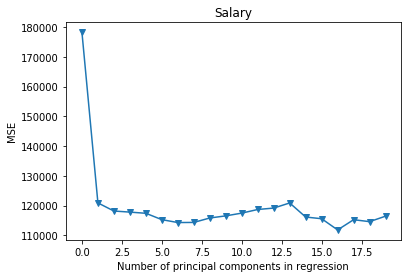

In [5]:
#Now we'll perform 10-fold cross-validation to see how it influences the MSE:
n = len(X_reduced)
kf_10 = model_selection.KFold( n_splits=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*model_selection.cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot results    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

We see that the smallest cross-validation error occurs when  M=18  components are used. This is barely fewer than  M=19 , which amounts to simply performing least squares, because when all of the components are used in PCR no dimension reduction occurs. However, from the plot we also see that the cross-validation error is roughly the same when only one component is included in the model. This suggests that a model that uses just a small number of components might suffice.

We'll calculate the amount of variance explained by adding each consecutive principal component:

In [7]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 38.88,  60.89,  71.38,  79.51,  84.78,  89.18,  92.68,  95.18,
        96.5 ,  97.46,  98.12,  98.73,  99.22,  99.53,  99.78,  99.91,
        99.98, 100.  , 100.01])

Setting  M=1  only captures 38.88% of all the variance, or information, in the predictors. In contrast, using  M=6  increases the value to 89.18%. If we were to use all  M=p=19  components, this would increase to 100%.

Now let's perform PCA on the training data and evaluate its test set performance:

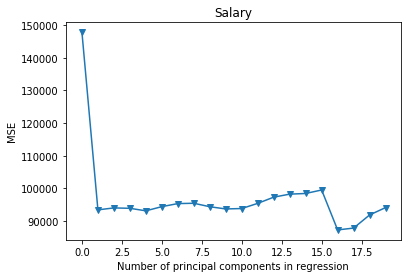

In [9]:
pca2 = PCA()

# Split into training and test sets
X_train, X_test , y_train, y_test = model_selection.train_test_split(X, y, test_size=0.5, random_state=1)

# Scale the data
X_reduced_train = pca2.fit_transform(scale(X_train))
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = model_selection.KFold( n_splits=10, shuffle=True, random_state=1)

mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*model_selection.cross_val_score(regr, X_reduced_train[:,:i], y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

We find that the lowest cross-validation error occurs when  M=18  components are used. Now we'll see how it performs on the test data and compute the test MSE as follows:

In [10]:
X_reduced_test = pca2.transform(scale(X_test))[:,:7]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:7], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
print('Mean Square Error is :',mean_squared_error(y_test, pred)/10000,'%')

Mean Square Error is : 14.276908858137572 %


This test set MSE is competitive with the results obtained using ridge regression and the lasso. However, as a result of the way PCR is implemented, the final model is more difficult to interpret because it does not perform any kind of variable selection or even directly produce coefficient estimates.

# Partial Least Squares

(-1, 19.9)

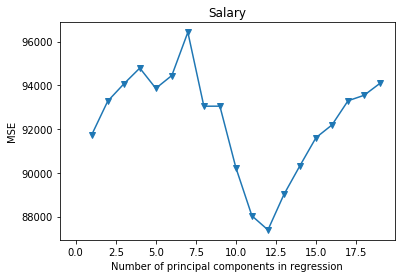

In [11]:
n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)

mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = model_selection.cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

# Plot results
plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1)

The lowest cross-validation error occurs when only  M=2  partial least squares dimensions are used. We now evaluate the corresponding test set MSE:

In [12]:
pls = PLSRegression(n_components=2)
pls.fit(scale(X_train), y_train)

print('Mean Square Error is :',mean_squared_error(y_test, pls.predict(scale(X_test)))/10000,'%')

Mean Square Error is : 14.58349840584714 %


The test MSE is comparable to the test MSE obtained using PCR !!!

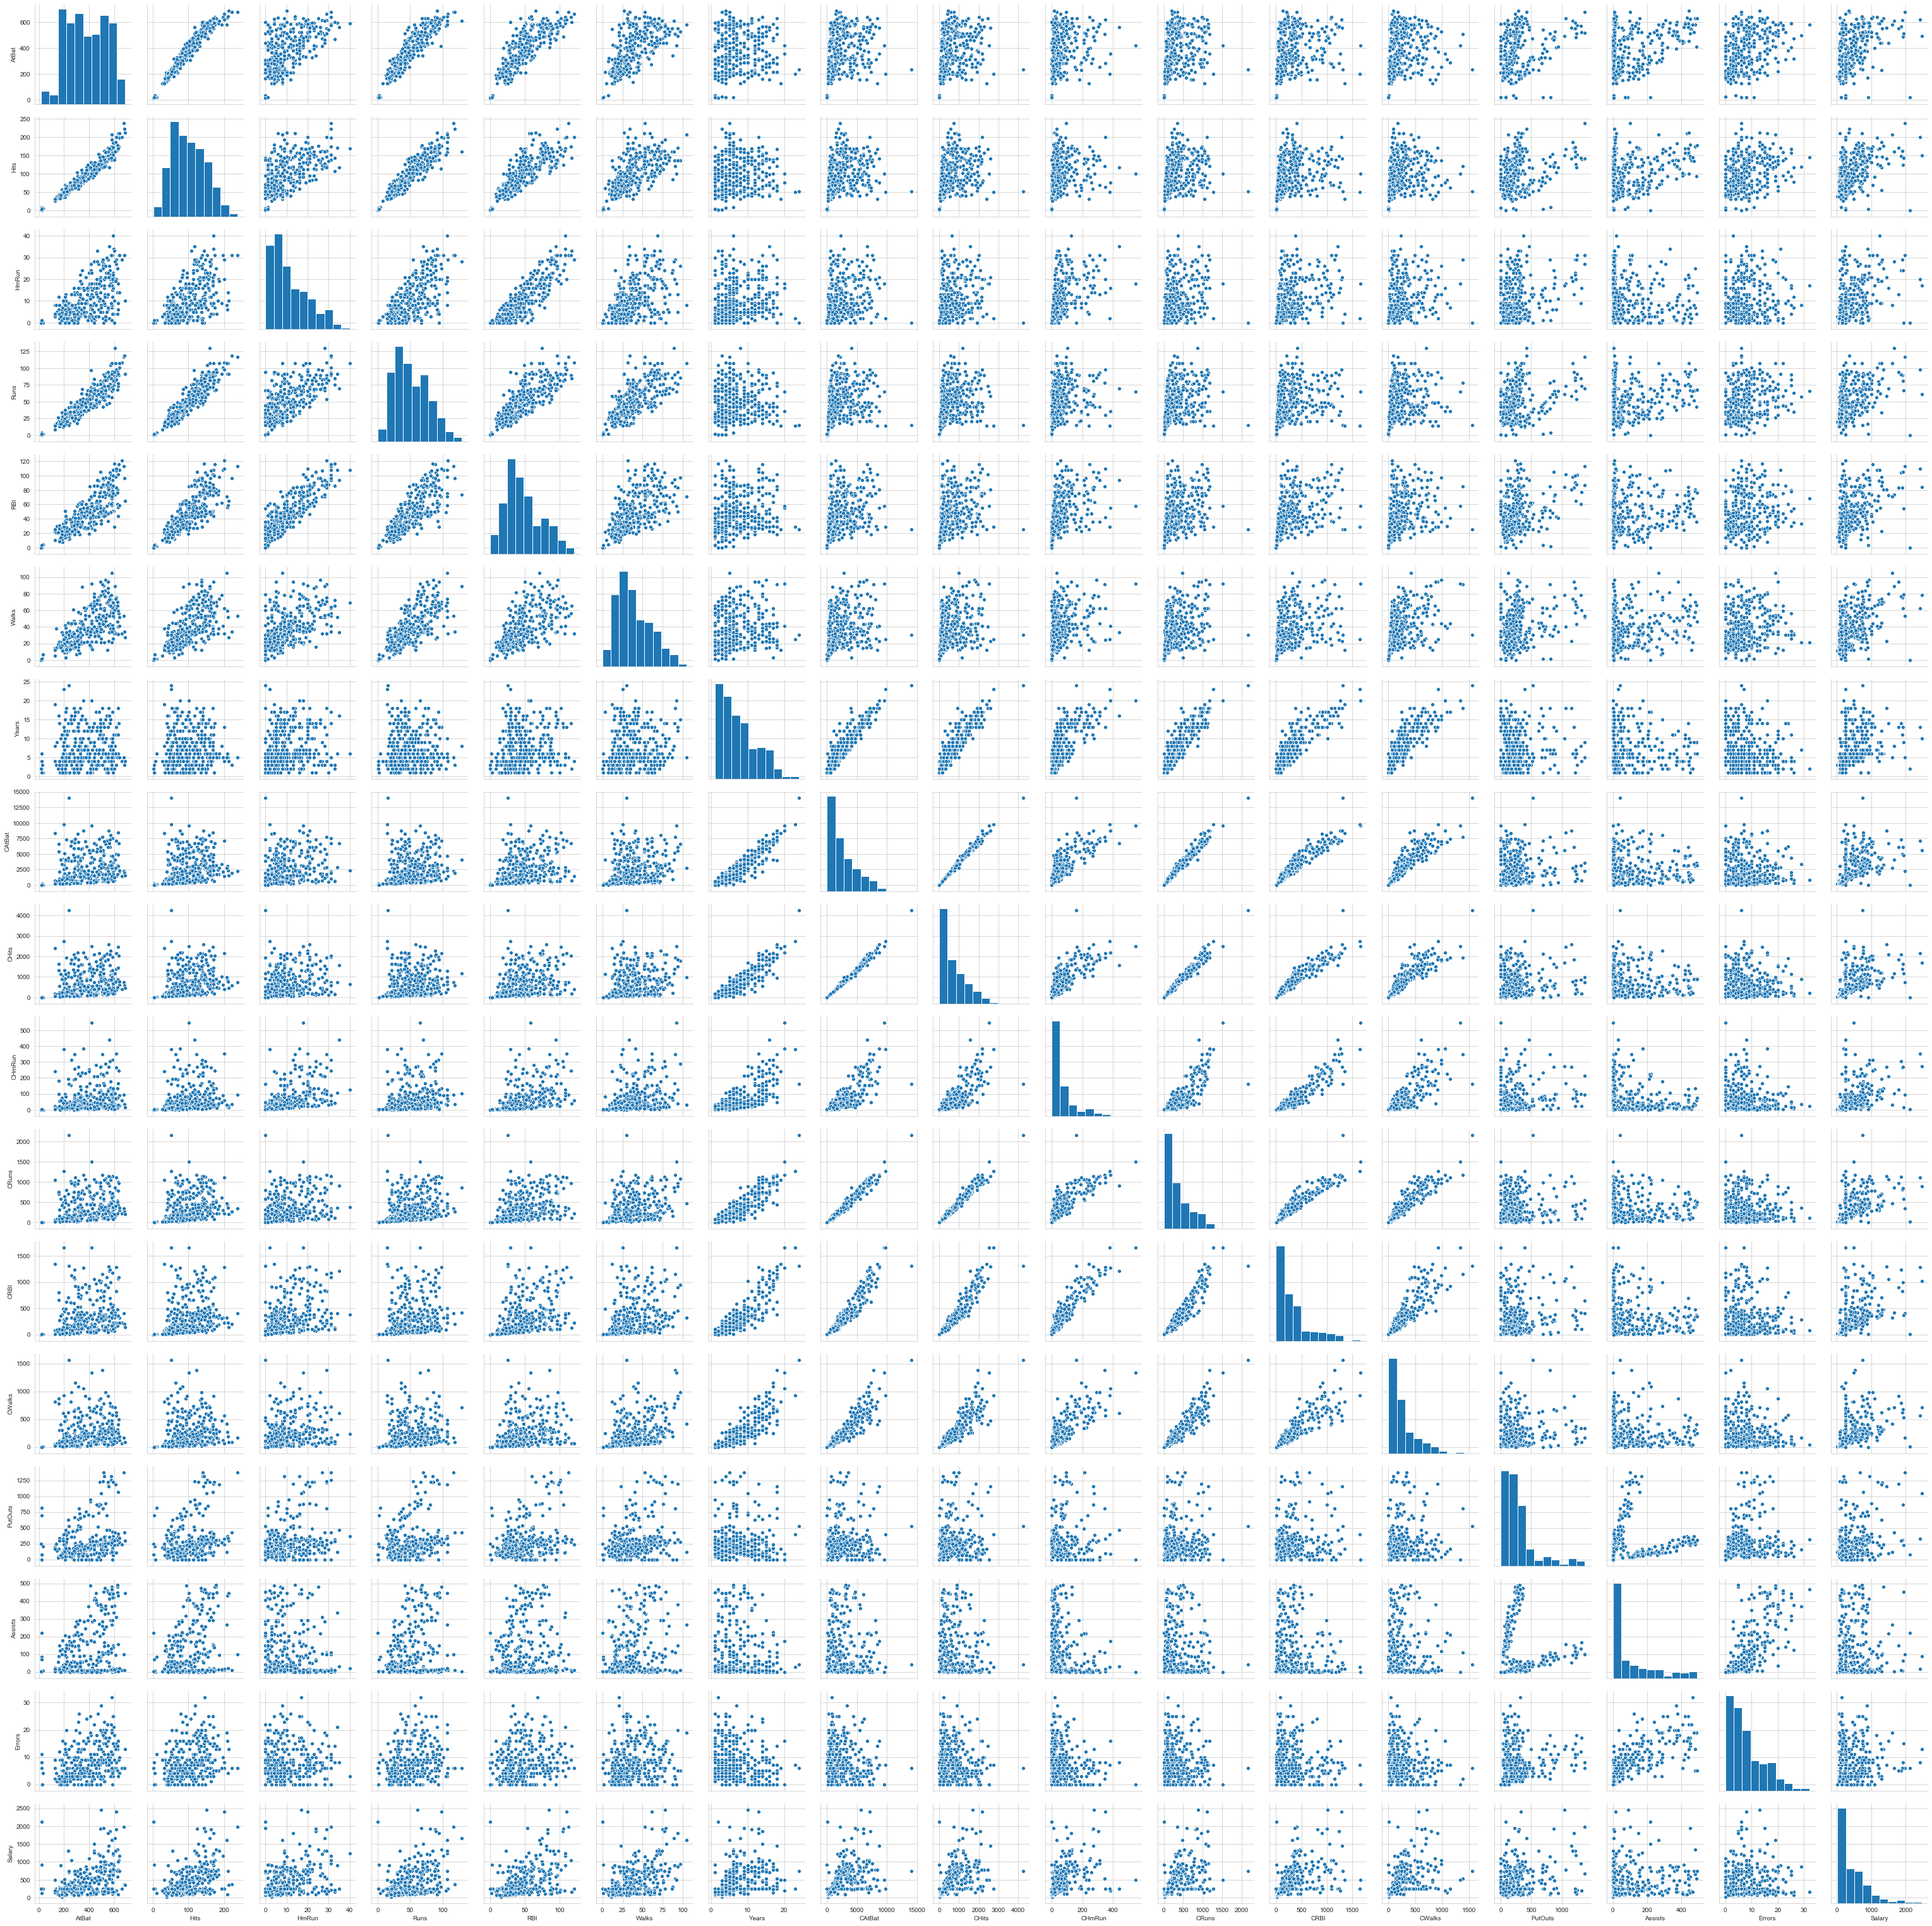

In [46]:
import seaborn as sns
sns.set_style('whitegrid')
sns.pairplot(pd.DataFrame(df))